<a href="https://colab.research.google.com/github/snxly/colab/blob/master/batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API
## matplotlib
- hist(list, size)  # list中每个值的分布

# 问题1：初始化的问题， 导致第一次循环的loss过高
初始化loss过高的问题是，我们需要花费一定的精力（开始的iterations）来把loss降下来。
如果loss一开始就比较低，那我们的iterations就用在了比较有意义的地方。  
那么，怎么让初始的loss比较低呢？

通过代码，我们从后往前想办法解决这个问题
```python
emb = C[X].view(X.shape[0],-1)
h = emb @ W1 + b1
h = tanh(h)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
```



## 1. logit越大，会导致loss越高，因此第一个方案是压缩 W2 和 b2以降低 logits
```python
## W2 = W2 * 0.01
W2 = torch.randn(h2_in, h2_out, generator = g) * 0.01
# b2 = b2 * 0
b2 = torch.randn(h2_out,        generator = g) * 0
```

## 2. 再往前 h=tanh(h)
这就比较有意思了，因为我们之前写过 tanh 的backward
```python
t = tanh(self.data) // 这里直接用tanh代替forward计算过程
self.grad = (1-t**2) * out.grad
```
可以看到
1. 如果 t=1/-1, 即进入了tanh比较平坦的区域，那么 (1-t**2) 就趋近于0，相当于
阻止了将 out_grad 向前传递。
2. 如果 t=0, 相当于透传 gradient

视频里，用直方图对tanh的结果做了可视化
```python
# show hist of h
import matplotlib.pyplot as plt
plt.hist(h.view(-1).tolist(), 50)
```


### 从直方图可以很直观的看出，tanh的值大量集中在了 -1/1 附近。

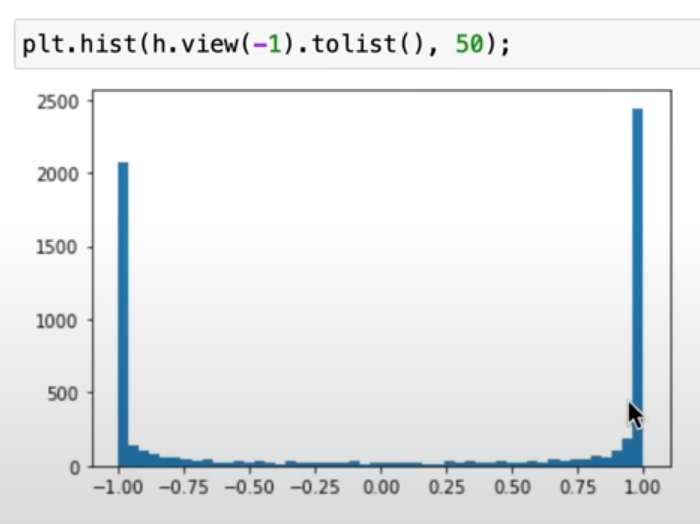

### 同样的，我们可以可视化 tanh 的input
```python
# show hist of h_input
plt.hist(h_input.view(-1).tolist(), 50)
```


---



### 从直方图可以很直观的看出，tanh input值的范围很广, 事实上 input>3 时，tanh就>0.99 了

In [7]:
import torch
torch.tanh(torch.tensor(3))

tensor(0.9951)

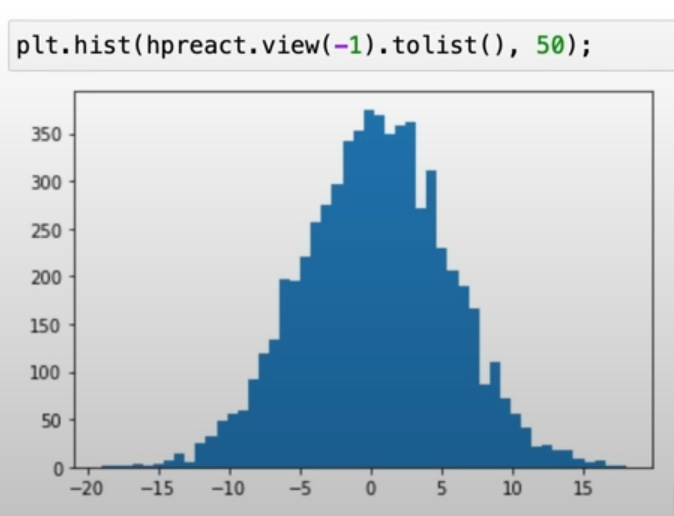

### 当我们把tanh的结果在两个维度上做可视化, 可以看到每个neuron的情况
如果某一列（一个neuron）全是白色（>0.99）,表示这个neuron完全阻止了gradient的传递。**也就是说，这是个死掉的neuron**。


前面的可视化是一个维度（h.view（-1））
```python
# show hist of h_input
plt.figure(figsize=(20,10))\
plt.imshow(h.abs > 0.99, cmap='gray', interpolation='nearest')\
```

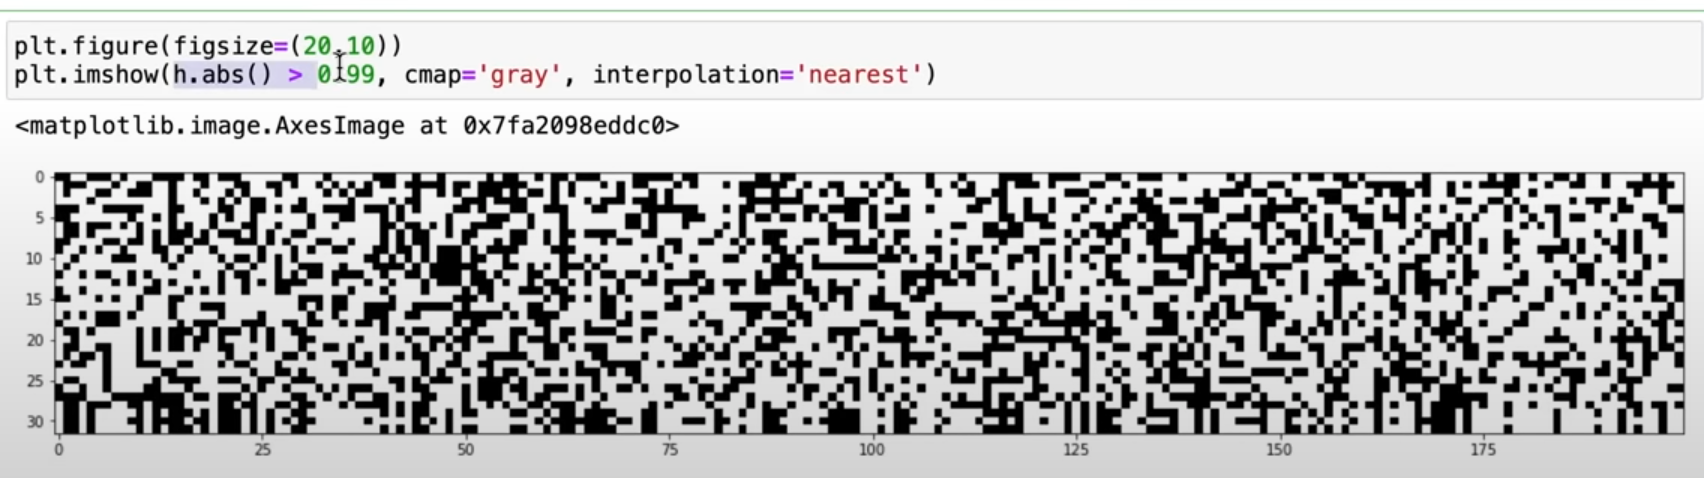

### Q:这里有个问题，没搞明白。
视频里提到如果一个 neuron 死掉了，那么以后任何的sample都不能将其激活，即这个neuron会永久地死掉。不懂为什么会‘永久地’死掉？

## 那如何减小 tanh 的input呢？

看代码
```python
h = emb @ W1 + b1
```
类似的，我们可以减小 W1 和 b1
```python
## W1 = W1 * 0.01
W1 = torch.randn(h1_in, h1_out, generator = g) * 0.01
# b1 = b1 * 0
# 实践表明，这里取0.01可能有些帮助
b1 = torch.randn(h1_out,        generator = g) * 0.01
```





然后，我们再次看一下刚才可视化生成的那几张图
1. tanh input的直方图
2. tanh 结果的直方图
3. tanh结果的二维化视图 (看每一列neuron的情况)  
很显然，比刚才的结果好了很多

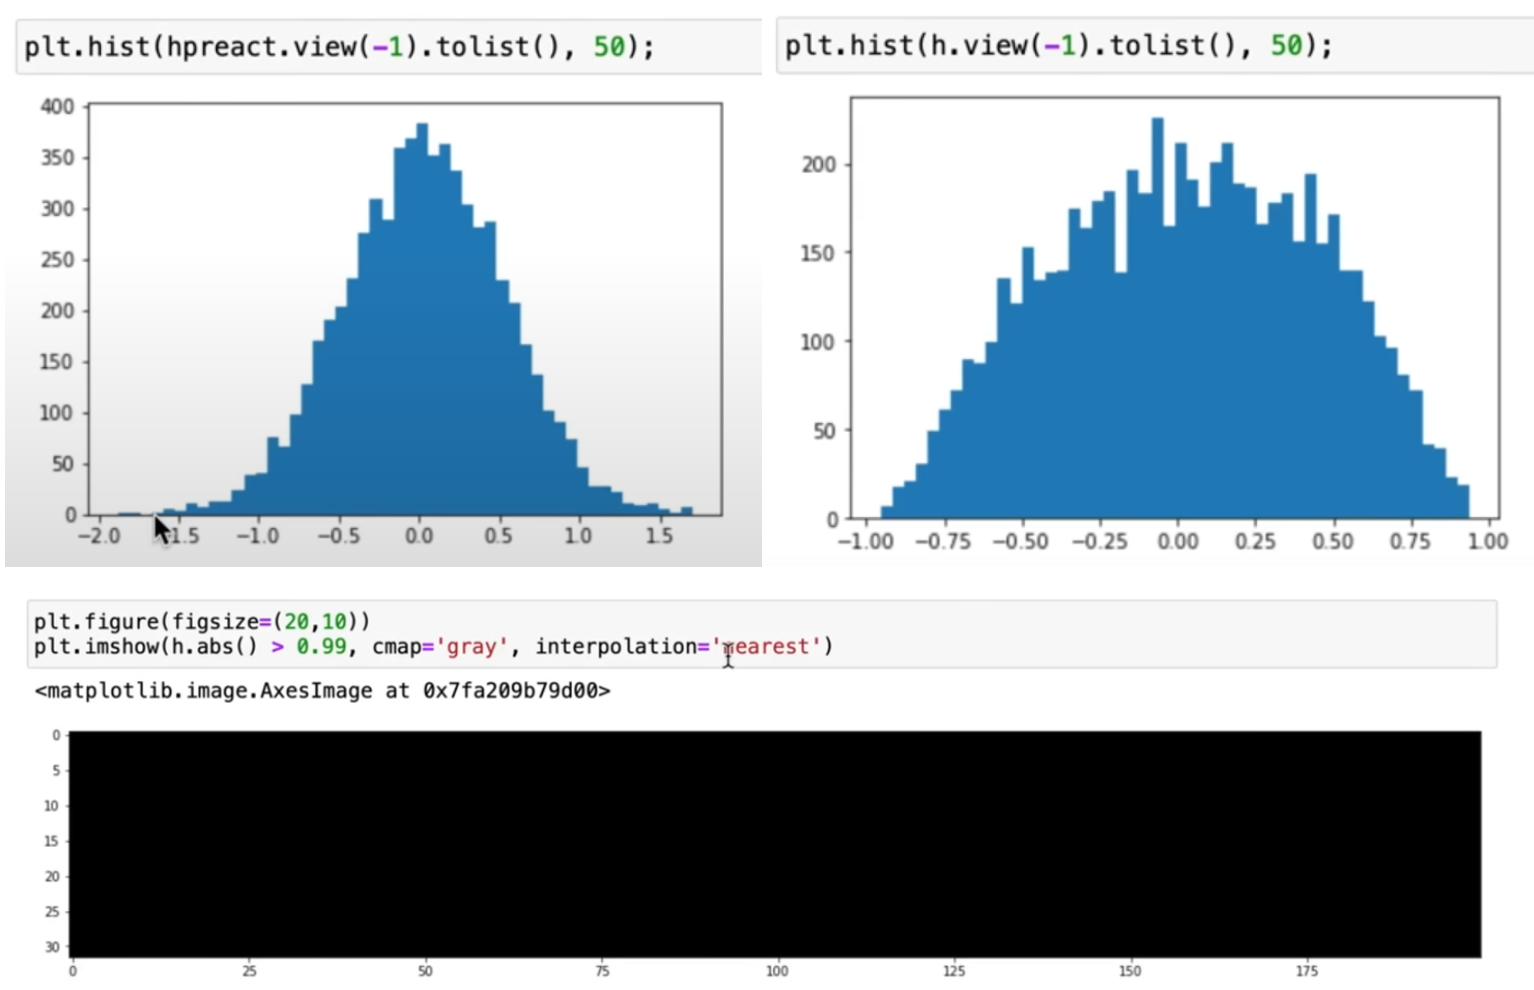

## 至此，我们解决了问题一，也就是初始化的问题。

# 问题2：手动scale w/b 的替代方案
## 问题描述： 两个标准的（u=0,std=1）正态分布,做点积以后，结果不再是标准的正泰分布

In [3]:
import torch
x = torch.randn(100, 5)
print(x.mean(), x.std())
w = torch.randn(5,20)
print(w.mean(), w.std())
h = x @ w
print(h.mean(), h.std())

tensor(-0.0298) tensor(1.0552)
tensor(0.1824) tensor(0.9353)
tensor(-0.0135) tensor(2.2652)


然而，我们的目标是，希望在网络中传递的数据，**能一直保持标准正太分布的形态**  
一个简单的做法是，w = w * (fan_in ** -0.5), 即除以fan_in的平方根

In [18]:
x = torch.randn(100, 5)
print(x.mean(), x.std())
w = torch.randn(5,20) * (5 ** -0.5)
print(w.mean(), w.std())
h = x @ w
print(h.mean(), h.std())

tensor(-0.0151) tensor(1.0104)
tensor(0.0045) tensor(0.4670)
tensor(-0.0032) tensor(1.0947)


要实现类似的目标，有一个现成的API是： torch.nn.init.kaiming_normal

Q: 这里也有个问题，kaiming处理之后的std并不是1，似乎目标并不是处理成1.  
后续如果明白了，我再来补充把。

In [33]:
x = torch.randn(100, 5)
print(x.mean(), x.std())
w = torch.randn(5,20)
torch.nn.init.kaiming_normal_(w, mode='fan_in', nonlinearity='linear')
print(w.mean(), w.std())
h = x @ w
print(h.mean(), h.std())

tensor(-0.0045) tensor(0.9685)
tensor(-0.0088) tensor(0.2302)
tensor(0.0088) tensor(0.4959)


# Basically, 这是紧接着上一个课程的又一个优化，可称 ‘改进5’
- 改进1： cross-entropy
- 改进2： mini-batch
- 改进3： set learning-rate properly
- 改进4： 3 splits to check overfitting
- 改进5： 初始化 weights with kaiming_normalize_

# Batch Normalization （40:51）
Normalization的思路是：  
既然我们希望将` x @ w` 的结果变成一个标准正态分布，那与其通过调整w来做到这一点，为什么不对结果直接做normalization呢？？  

```python
# before
# we calculate activations and logits
h = x @ w + b # activations
h = tanh(h) # logits
```

## 1. 在non-linear(tanh) 之前做normalization

```python
hpreact = x @ w + b
# 1. Normalization
# 这里在维度0上做normalziation, 相当于是对所有的sample取平均
# 这里的sample是 mini-batch sample
# 因此，这种normalization，我们称之为 batch-normalization
# 可以理解为 normalization based on mini-batch samples
# mini-batch mean
mean = hpreact.mean(0, keepdim=True)
# min-batch variance
std = hpreact.std(0, keepdim=True)
# normalize
h = (hpreact - mean) / std
# non-linear based on normalized data
logits = tanh(h)
```


## 2. scale and shift
然而，随着训练过程的推进，这个结果`h`并不总是**标准**正态分布的，可能在标准正太分布的基础上，做了一些拉伸和偏移。那么这个拉伸和偏移量，我们也通过 `back propagation` 自行学习。

```python
# init scale and shift parameter
bnscale = torch.ones(1, h1_out) # bngain
bnshift = torch.zeros(1, h1_out) # bnbias
parameters = [C, W1, b1, W2, b2, bnscale, bnshift]
for p in parameters:
      p.requred_grad = True
```
```python
hpreact = x @ w + b
mean = hpreact.mean(0, keepdim=True)
std = hpreact.std(0, keepdim=True)
h = (hpreact - mean) / std
# scale and shift
h = bnscale * h + bnshift
# non-linear based on normalized data
logits = tanh(h)
```

## 3. nomalization, scale and shift in split_loss caculation
别忘了，在计算split_loss的时候，也需要做同样的normalization


```python
X_train, Y_train = build_split_data()
emb = C[X_train]
hpreact = emb.view(X_train.shape[0],-1) @ W1 + b1
# normalization
mean = hpreact.mean(0, keepdim=True)
std = hpreact.std(0, keepdim=True)
h = (hpreact - mean) / std
h = bnscale * h + bnshift
# non-linearity
logits = tanh(h)
```



整个过程如下图所示：

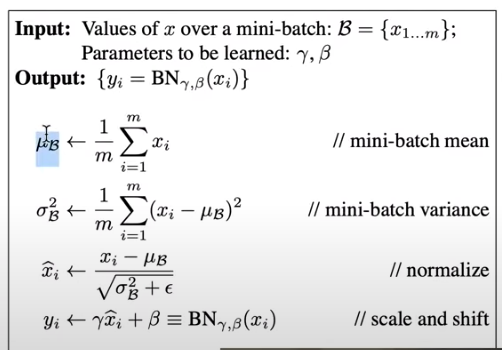

## batch normalization的问题与改进

Batch normalization的问题在于，mean 和 std是基于mini-batch里的所有的sample得到的结果，也就是说这些sanmple是耦合的。  
另外有一些去掉耦合性的 normalization 方式，比如
- linear normalization
- instant normalization
- group normalization

为了解耦合，视频里提到了一种运行时计算统一的 mean 和 std的方式，我感觉不太重要，忽略了。


## batch normalization 拾遗
1. 在做normalization的时候，获取 std 完整的公式是 （std^2 + epsilon）^ 0.5, epsilon的作用是为了防止 除数是0
2. 有了batch normalization以后，linear就不再需要bias了，因为在linear里加的bias，都会因为‘-mean’被忽略掉
```python
h = x @ w + b
mean = h.mean(0, keepdim=True)
std = h.std(0, keepdim=True)
# b 会在这里被忽略掉，所以没有必要
h = (h - mean) / std
```

## Batch normalization in Pytorch
torch.nn.Batchnorm1d

|parameter| comments |
|--|--|
|num_features|等价于 n_hidden, 用于初始化 bnscale, bnshift, bnmean_running, bnstd_running 等参数|
|epsilon|防止除数为0，默认值即可|
|momentum|用于计算 bnmean_running, bn_std_running 的移动平均数|
|affline|bnscale, bnshift 是否可学习，建议always set as True|
|track_running_stats|是否计算 bnmean_running, bnstd_running|
|device| CPU or GPU|
|dType||

### Example
```python
# With Learnable Parameters
m = nn.BatchNorm1d(100)
h = emb.view(emb.shape[0], -1) @ w
h_bn = m(h)
logits = torch.tanh(h_bn)
```




# 将之前的代码 pytorch 化

In [ ]:
# Linear
# BatchNorm1d
# Tanh
vocab_size = 27
embedding_dimension = 2
block_size = 3
n_hidden = 100
C = torch.randn((vocab_size, embedding_dimension))
layers = [
    Linear(embedding_dimension * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                        n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                        n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                        n_hidden, vocab_size)
]

for i in range(1000):
  # mini-batch
  idx = torch.randint(0, Xtr.shape[0], (32,))
  x_batch = Xtr[idx]
  y_batch = Ytr[idx]

  # forward
  emb = C[x_batch]
  h = emb.view(emb.shape[0], -1)
  for layer in layers:
    h = layer(h)
  loss = F.cross_entropy(h, y_batch)

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # udpate data
  for p in parameters:
    p.data += -0.1 * p.grad



# 总结
视频最后半小时，展示了，如果没有 batch normalization, 要达到好的效果，需要非常精细的调教。  
有了normalization layer，kaiming_normalize这些精细的调教都不需要了，network现在变得非常的robust。

## 重点介绍了如何判断网络的状态，TODO：这部分没完全搞清楚
- forward status （每个neuron是够过于拥挤 tanh value > 0.97）
- backward status
- gradient 变化节奏 (判断 learning_rate 是否设置的合理)